# 분류

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

   - DESCR: 데이터 설명하는 키
   - data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 키
   - target: 레이블 배열을 담은 키

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

70,000장, 784개의 특성 (28 x 28 이미지)  
개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도

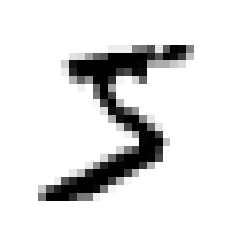

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

target값이 '5'로 문자열  
머신러닝 알고리즘은 숫자를 기대하므로 정수로 변환

In [10]:
import numpy as np

y = y.astype(np.uint8)

훈련 셋 & 테스트 셋 분리

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다.  
   - 데이터셋을 섞어 문제를 방지할 수 있다.

## 3.2 이진 분류기 훈련

In [12]:
# 5는 True, 다른 숫자는 False
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

분류 모델을 하나 선택해서 훈련 시작  
Sklearn의 SGDClassifier 클래스를 사용해 SGD 분류기로 시작해보기
   - SGD 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있다.
   - SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문 (온라인 학습에 최적)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

5를 5로 예측 >> 정확히 맞춘 case

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정
   - StratifiedKFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
   - cross_val_score

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for tr_idx, te_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[tr_idx]
    y_train_folds = y_train_5.iloc[tr_idx]
    X_test_fold = X_train.iloc[te_idx]
    y_test_fold = y_train_5.iloc[te_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 숫자가 5이기 때문에 무조건 5 아님으로 예측하면 정확도가 90%  
정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 볼 수 있음. (특히 불균형한 데이터셋)

### 3.3.2 오차 행렬 Confusion Matrix
   - 오차 행렬을 만들려면 실제 타깃과 비교할 수 있는 예측값을 만들어야 함.
   - cross_val_predict()
       - k-fold 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환
       - 훈련셋의 모든 샘플에 대해 깨끗한 예측 (깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대한 예측)

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차행렬의 행: 실제 클래스  
   - 첫번째 행: 5 아님
   - 두번째 행: 5
오차행렬의 열: 예측 클래스
   - 첫번째 열: 5 아님으로 예측
   - 두번째 열: 5로 예측
   
   
  - 53892는 5 아님을 5아님으로 정확하게 예측 (실제 음성, TN)
  - 687은 5 아님을 5라고 예측 (거짓 양성, FP)
  - 1891은 5를 5아님으로 예측 (거짓 음성, FN)
  - 3530은 5를 5라고 정확하게 예측 (실제 양성, TP)

#### Confusion Matrix Img
<img src="confusionMatrix.PNG"  width="700" height="370">

### 3.3.3 정밀도와 재현율

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

#### F1 Score: 정밀도와 재현율의 조화평균

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 스코어가 높다.  
이게 항상 바람직한 것은 아니다. (상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음)  
   - 높은 정밀도 중요: 어린아이에게 안전한 동영상 걸러내는 분류기
       - 재현율이 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 (낮은 재현율) 안전한 것들만 노출 (높은 정밀도)
   - 높은 재현율 중요: 감시 카메라 도둑 잡아내는 분류기
       - 경비원이 잘못된 호출을 종종 받게 되지만, 거의 모든 도둑을 잡을 것
       
  
  정밀도/재현율 트레이드오프: 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지

### 3.3.4 정밀도/재현율 트레이드오프
   - 임곗값
       - 임곗값을 높이면 거짓 양성이 진짜 음성이 되어 정밀도가 높아지고 재현율은 줄어든다.
       - 임곗값을 낮추면, 재현율이 높아지고 정밀도가 줄어든다.
       
#### 정밀도/재현율 트레이드오프 Img
<img src="Precision_Recall_Tradeoff.PNG"  width="700" height="370">

분류기의 predict() 메서드 대신 decision_fuction() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.  
이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

임곗값이 0이므로 predict와 동일한 결과 반환  
임곗값이 8000일때는 재현율이 줄어든다는 것을 보여줌.
  
  
그렇다면 적절한 임곗값을 어떻게 정할 수 있는가?
   - cross_val_predict() 함수를 사용해 훈련 셋에 있는 모든 샘플의 점수를 구해야 한다.
   - 결정 함수를 반환받도록 지정해야 함.
     

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

#### precision_recall_curve()
   - 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

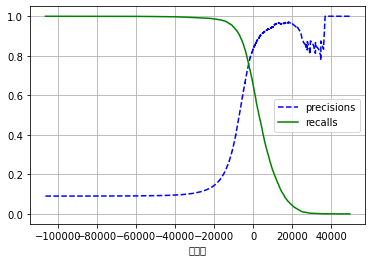

In [40]:
import warnings
warnings.filterwarnings('ignore')

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions")
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls")
    plt.legend()
    plt.xlabel("임곗값")
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions,recalls, thresholds)
plt.show()

정밀도 곡선이 재현율 곡선보다 왜 더 울퉁불퉁한가?
   - 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문. (일반적으로는 높아져야 함.)
   - 가운데 임곗값에서 오른쪽으로 숫자 하나만큼 이동하면 어떻게 될까요?
       - 정밀도는 올라가고 재현율은 내려간다.

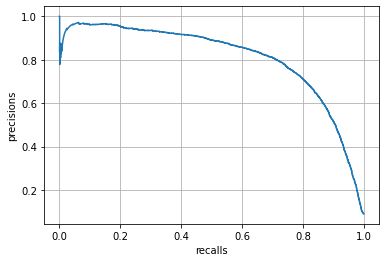

In [44]:
plt.plot(recalls[:-1], precisions[:-1])
plt.grid()
plt.xlabel("recalls")
plt.ylabel("precisions")
plt.show()

재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함.  
이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.  
ex. 재현율 60% 정도 지점 (물론 프로젝트에 따라 선택이 달라진다.)  
  
정밀도 90% 달성 목표로 가정)
   - 현재임곗값은 약 8,000정도
   - 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾을 수 있음.

In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
threshold_90_precision

3370.0194991439557

In [47]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
   - 수신기 조작 특성 (ROC) 곡선도 이진 분류에서 널리 사용하는 도구
   - 거짓양성비율(FPR)에 대한 진짜 양성 비율 (TPR, 재현율의 다른 이름)의 곡선
   - FPR: 1-특이도
   
#### ROC 곡선 Img
<img src="ROC_curve.PNG"  width="700" height="370">

#### roc_curve

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

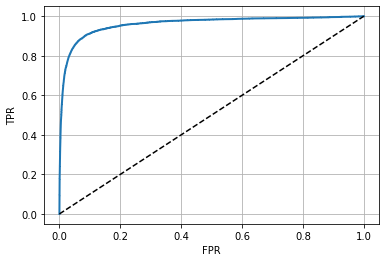

In [51]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # 대각 점선
    plt.grid()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
plot_roc_curve(fpr,tpr)
plt.show()

#### roc_auc_score
    - AUC 곡선 아래의 면적
    - 완벽한 분류기는 roc의 auc가 1
    - 완전한 랜덤 분류기는 0.5

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC 곡선이 정밀도/재현율 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있다.  
일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용  
그렇지 않으면 ROC곡선을 사용
  
ex)
   - ROC곡선을 보면 매우 좋은 분류기라 생각할 수 있다.
   - 하지만, 음성(5 아님)에 비해 양성(5)이 크게 적기 때문
   - 이와는 다르게 PR곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여준다.

RandomForestClassifier를 훈련해 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

RandomForestClassifier는 decision_function 메서드가 없고 predict_proba가 있음

In [54]:
# 양성 클래스에 대한 확률을 점수로 사용
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_torest = roc_curve(y_train_5, y_scores_forest)

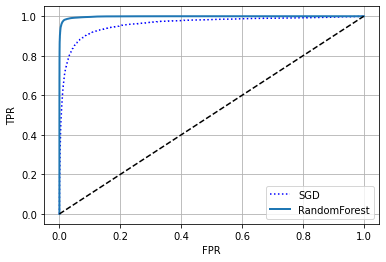

In [55]:
plt.plot(fpr,tpr,"b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

ROC 곡선 비교
   - 랜덤포레스트가 훨씬 좋음
   - 왼쪽 위 모서리에 더 가까워 auc값이 더 크기 때문

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류
   - 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다.
       - 이를 OvR(one-versus-the-rest) 전략이라고 한다.
       - 또는 OvA(one-versus-all) 전략이라고도 한다.
   - 또 다른 전략은 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
       - 이를 OvO(one-versus-one) 전략이라고 한다.
       - 클래스가 N개라면 분류기는 Nx(N-1)/2개 필요
       - MNIST의 경우 10X9/2
       - 이미지 하나를 분류하려면 45개 분류기 모두 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택
       - OvO 전략 장점: 각 분류기의 훈련에 전체 훈련 셋 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것
       
  
SVM과 같은 일부 알고리즘은 훈련 셋의 크기에 민감해서 큰 훈련 셋에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 셋에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호한다. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다.
  
다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행

#### OvR과 OvO Img
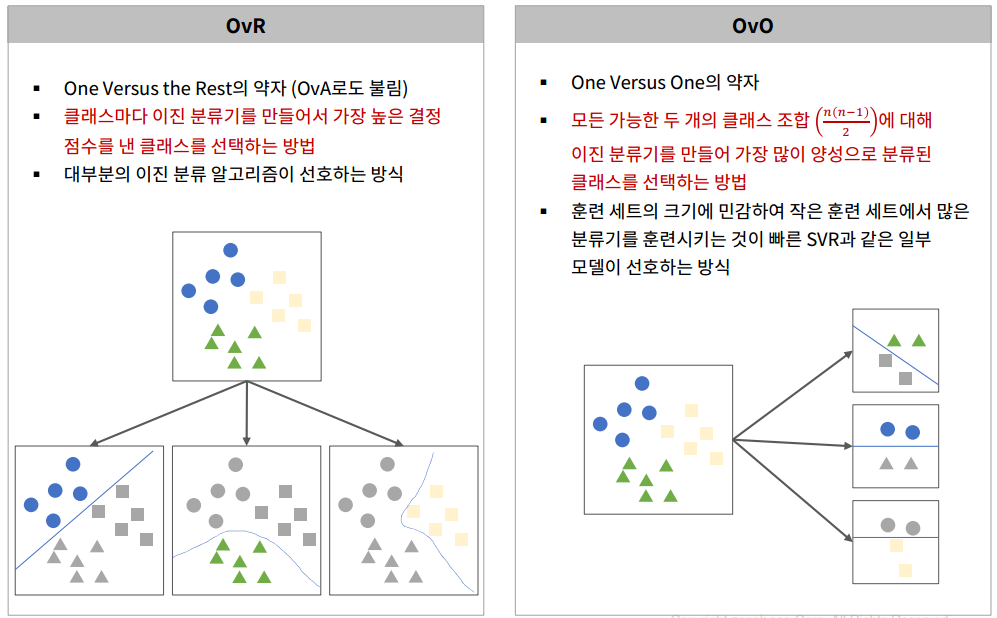

In [57]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

이 코드는 0에서 9까지의 원래 타깃 클래스를 사용해 SVC 훈련  
그런 다음 예측 (5를 5로 정확히 예측)  
내부에서는 사이킷런이 OvO 전략을 사용해 45개의 이진분류기를 훈련시키고 각각의 결정점수를 얻어 점수가 가장 높은 클래스 선정

정말 그런지 확인해보는 작업 decision_function
   - 호출하면, 샘플당 10개의 점수 반환

In [58]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

가장 높은 점수가 클래스 5에 해당

In [59]:
np.argmax(some_digit_scores)

5

In [60]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [61]:
svm_clf.classes_[5]

5

분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장  
각 클래스의 인덱스가 클래스 값 자체와 같다. 하지만 일반적으로 이런 경우 드뭄

#### OneVsOneClassifier와 OneVsRestClassifier
   - 사이킷런에서 OvO나 OvR 강제 사용하기
   

In [62]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
len(ovr_clf.estimators_)

10

In [64]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [65]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

결과를 보면, 분류기가 예측 결과에 강한 확신을 보이고 있음  
대부분의 점수가 큰 음수, 반면 클래스 5의 점수는 2412.5  
이 모델은 573.5의 점수를 얻은 클래스 3을 조금 의심

#### cross_val_score 함수를 사용한 분류기 평가

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84% 이상을 얻음  
입력의 스케일을 조정하여 정확도를 올려보자

In [67]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

1. 데이터 준비 단계에서 가능한 선택 사항 탐색
2. 여러 모델 시도
3. 그 중 좋은 몇개를 골라 GridSearchCV를 사용해 하이퍼파라미터 튜닝
4. 자동화

#### cross_val_predict 함수를 사용한 에러 분석

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

#### matshow() 함수를 사용한 이미지 표현

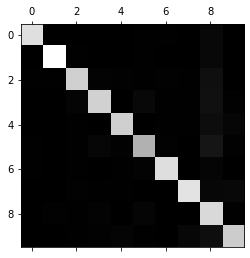

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

대부분의 이미지가 올바르게 분류되었음을 나타내는 주 대각선에 있으므로 매우 좋아 보임  
숫자 5는 다른 숫자보다 조금 더 어둡다.
   - 이는 데이터셋에 숫자 5의 이미지가 적거나
   - 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻
   
그래프의 에러 부분에 초점을 맞춰보자.
   1. 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
   

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주 대각선만 0으로 채워서 그래프를 그려보자.

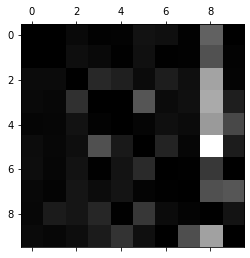

In [71]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있다.  
행은 실제 클래스, 열은 예측한 클래스  
   - 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시
   - 하지만, 8의 행은 그리 나쁘지 않다. >> 실제 8이 적절히 8로 분류되었다
   - 오차 행렬은 반드시 대칭인 것은 아니다. 3과 5가 서로 많이 혼동되고 있음
   - 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.
       - 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.
           - ex) 8처럼 보이는 (실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다.
           - ex2) 분류기에 도움 될 만한 특성을 더 찾아볼 수 있다. (동심원 수)
           - ex3) 동심원 같은 어떤 패턴이 드러나도록 이미지를 전처리해볼 수 있다.
       - 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래 걸린다.

3과 5의 샘플을 그려보자

In [72]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

In [118]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

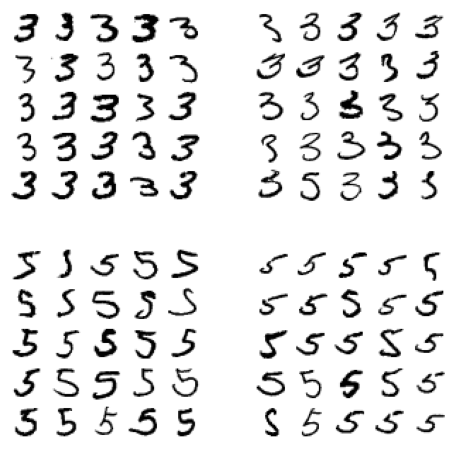

In [119]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지  
오른쪽 5x5 블록 두 개는 5로 분류된 이미지  
  
3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치  
숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 또 반대도 마찬가지  
다른 말로 하면 분류기는 이미지의 위치나 회전 방향에 매우 민감하다.  
  
  3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것

## 3.6 다중 레이블 분류
   - 같은 사진에 여러 사람이 등장한다면 어떻게 해야 할까?
   - [1,0,1] 앨리스 있음, 밥 없음, 찰리있음
   - 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다.

In [85]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다.  
첫 번째는 숫자가 큰 값 (7,8,9)인지 나타내고  
두 번째는 홀수인지 나타낸다.  
  
KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련  
(KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다.)

In [86]:
knn_clf.predict([some_digit])

array([[False,  True]])

올바르게 분류
   - 숫자 5는 크지 않고
   - 홀수이다.

#### 다중 레이블 분류기를 평가하는 방법
   - 적절한 지표는 프로젝트에 따라 다르다.
   - 예를 들어, 각 레이블의 F1 점수를 구하고
   - 간단하게 평균 점수를 계산

In [87]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

실제로는 아닐 수 있지만 모든 레이블의 가중치가 같다고 가정한 것  
앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것  
간단한 방법은 레이블에 클래스의 지지도 (즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주는 것  
이렇게 하려면 이전 코드에서 average='weighted'로 설정하면 된다.

## 3.7 다중 출력 분류
   - 다중 출력 다중 클래스 분류
   - 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것
   - 여기에서는 분류와 회귀 사이의 경계는 때때로 모호
       - 확실히 픽셀 강도 예측은 분류보다 회귀와 비슷
       - 더욱이 다중 출력 시스템이 분류 작업에 국한되지도 않는다.

먼저, mnist 이미지에 추출한 훈련 셋과 테스트 셋에 넘파이의 randint 함수를 사용하여 픽셀 강도에 잡음을 추가  
타깃 이미지는 원본 이미지가 될 것

In [90]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

테스트 셋에서 이미지 하나 선택 (여기서 테스트 데이터를 들여다 보는 것은 잘못된 것임을 눈치채야 함)  

In [116]:
y_train_mod

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
X_test_mod.iloc[some_index].values.reshape(1, -1).shape

(1, 784)

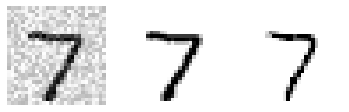

In [135]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 0
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plt.subplot(131); plot_digits(X_test_mod.iloc[some_index].values.reshape(1, -1))
plt.subplot(132); plot_digits(y_test_mod.iloc[some_index].values.reshape(1,-1))
plt.subplot(133); plot_digits(clean_digit)
plt.show()

타깃과 매우 비슷